# Indiana University Chest X-Rays

**Dataset Information**

* Open access chest X-ray collection from Indiana University
* Original source: https://openi.nlm.nih.gov/
* Original images were downloaded in raw [DICOM](https://en.wikipedia.org/wiki/DICOM) standard. Each image was converted to png using some post-processing:
* top/bottom 0.5% DICOM pixel values were clipped (to eliminate very dark or very bright pixel outliers)
* DICOM pixel values scaled linearly to fit into 0-255 range
* resized to 2048 on shorter side (to fit in Kaggle dataset limits)
* Metadata downloaded using available API (https://openi.nlm.nih.gov/services#searchAPIUsingGET)
* Each image classified manually into frontal and lateral chest X-ray categories.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./indiana_reports.csv")
df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


**Columns**

* `MeSH`: Medical Subject Headings, standardised medical vocab ([more info](https://www.nlm.nih.gov/bsd/disted/meshtutorial/introduction/02.html))
* `Problems`: medical conditions
* `image`: types of chest X-Ray (frontal/lateral) available
* `indication`: "a condition which makes a particular treatment or procedure advisable" ([source](https://www.medicinenet.com/script/main/art.asp?articlekey=32545))
* `findings`: observations regarding each part of the chest examined. Generally a paragraph with 4+ sentences
* `impression`: generally a one-sentence diagnostic based on findings reported. Can contain multiple sentences

In [3]:
import collections

set_to_other = [
    'pulmonary artery', 'bullous emphysema', 'pulmonary fibrosis', 'breast implants', 'lung, hyperlucent', 'sutures', 'tube, inserted', 'lung diseases, interstitial', 'volume loss', 'stents', 'bone and bones', 'mass', 'pneumothorax', 'osteoporosis', 'heart failure', 'shift', 'foreign bodies', 'shoulder', 'dislocations', 'mediastinum', 'spinal fusion', 'expansile bone lesions', 'lumbar vertebrae', 'subcutaneous emphysema', 'medical device', 'sclerosis', 'cysts', 'lucency', 'funnel chest', 'epicardial fat', 'blister', 'heart', 'bronchiectasis', 'mastectomy', 'pneumoperitoneum', 'aortic aneurysm', 'cervical vertebrae', 'heart atria', 'adipose tissue', 'trachea', 'sulcus', 'hypertension, pulmonary', 'cystic fibrosis', 'humerus', 'nipple shadow', 'hydropneumothorax', 'pectus carinatum', 'fibrosis', 'tuberculosis', 'sarcoidosis', 'colonic interposition', 'cholelithiasis', 'ribs', 'hernia, diaphragmatic', 'pleura', 'hyperostosis, diffuse idiopathic skeletal', 'heart ventricles', 'pneumonectomy', 'pericardial effusion', 'trachea, carina', 'bronchitis', 'thorax', 'contrast media', 'hypovolemia', 'abdomen', 'lymph nodes', 'cavitation', 'subcutaneous  emphysema', 'hemopneumothorax', 'bronchiolitis', 'blood vessels', 'hemothorax'
]

def parse_problem(line):
    line = list(set(line.lower().split(";")))
    return line

raw_problems = list(df["Problems"])
problems = []
problems_flat = []
counts = collections.defaultdict(int)

for line in raw_problems:
    line = parse_problem(line)
    clean_line = []
    for p in line:
        counts[p] += 1
        if p not in set_to_other:
            clean_line.append(p)
        else:
            clean_line.append("other")
    clean_line = list(set(clean_line))
    problems.append(clean_line)
    problems_flat += clean_line

categories = list(set(problems_flat))
categories.sort()
print("Number of categories:", len(categories))

Number of categories: 48


In [10]:
print(categories)

['airspace disease', 'aorta', 'aorta, thoracic', 'arthritis', 'atherosclerosis', 'bone diseases, metabolic', 'calcified granuloma', 'calcinosis', 'cardiac shadow', 'cardiomegaly', 'catheters, indwelling', 'cicatrix', 'consolidation', 'costophrenic angle', 'deformity', 'density', 'diaphragm', 'diaphragmatic eventration', 'emphysema', 'fractures, bone', 'granuloma', 'granulomatous disease', 'hernia, hiatal', 'implanted medical device', 'infiltrate', 'kyphosis', 'lung', 'markings', 'no indexing', 'nodule', 'normal', 'opacity', 'osteophyte', 'other', 'pleural effusion', 'pneumonia', 'pulmonary atelectasis', 'pulmonary congestion', 'pulmonary disease, chronic obstructive', 'pulmonary edema', 'pulmonary emphysema', 'scoliosis', 'spine', 'spondylosis', 'surgical instruments', 'technical quality of image unsatisfactory ', 'thickening', 'thoracic vertebrae']


In [4]:
"""
# convert cases < 30 examples to "other" class
set_to_other = []
for p in counts.keys():
    count = counts[p]
    if count < 30:
        set_to_other.append(p)
print(set_to_other)
"""

'\n# convert cases < 30 examples to "other" class\nset_to_other = []\nfor p in counts.keys():\n    count = counts[p]\n    if count < 30:\n        set_to_other.append(p)\nprint(set_to_other)\n'

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

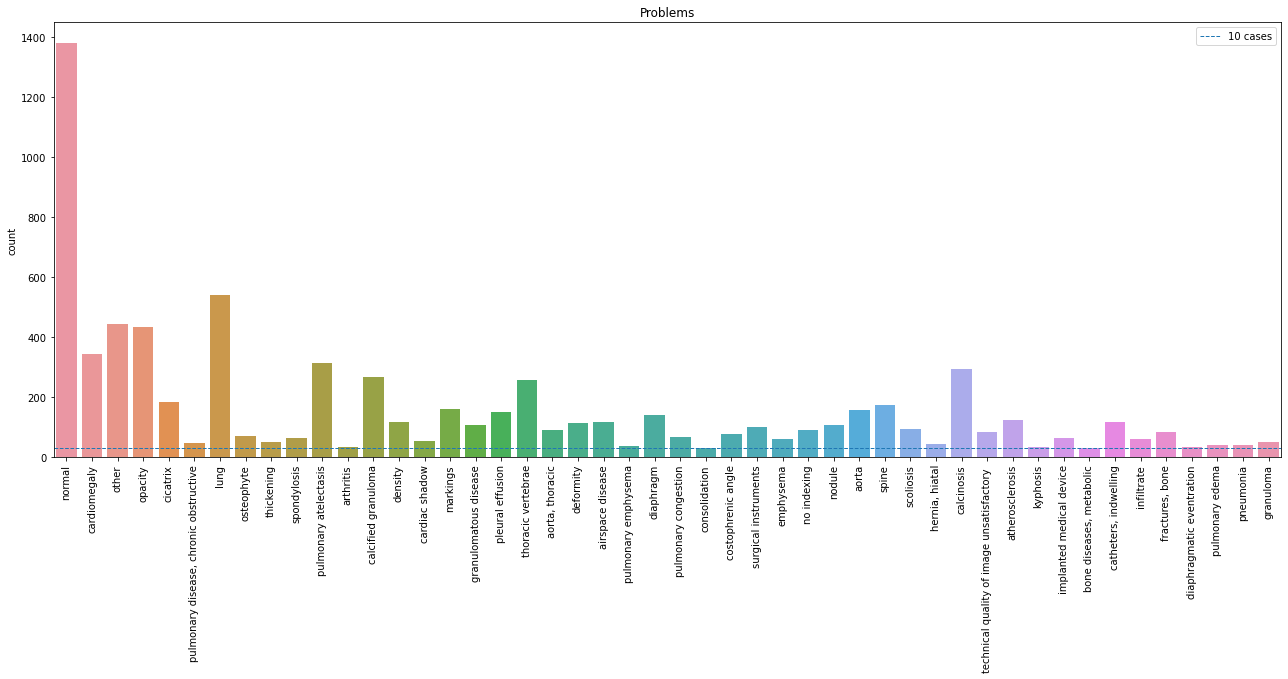

In [6]:
plt.figure(figsize=(22,8))
plt.title("Problems")
sns.countplot(problems_flat)
plt.xticks(rotation=90)
plt.axhline(30, linewidth=1, linestyle="--", label="10 cases")
plt.legend()
plt.show()

In [7]:
drop_col = ["MeSH", "Problems", "image", "indication", "comparison"]
df_new = df.drop(drop_col, axis = 1)
df_new.insert(1, "problems", problems)
df_new.fillna("No findings.", inplace=True)
df_new.head()

,uid,problems,findings,impression
0,1,[normal],The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,"[cardiomegaly, other]",Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,[normal],No findings.,"No displaced rib fractures, pneumothorax, or p..."
3,4,"[other, opacity, cicatrix, pulmonary disease, ...",There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,"[lung, osteophyte, thickening]",The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [8]:
df_new.to_csv("./cleaned_reports.csv")